# Single-cell ATAC-seq data analysis

### In scRNA-seq-like manner using scanpy



In [9]:
import anndata
from scipy.io import mmread
import scanpy as sc
import scipy
import numpy as np
import pandas as pd

In [2]:
np.random.seed(0)

In [3]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './figures/' # specifying output directory for figures
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.4 scipy==1.3.2 pandas==0.25.3 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [4]:
path = './'

### Reading in metadata

In [5]:
sample_info = pd.read_csv(path + 'qc_all.csv', index_col=0)
sample_info.set_index('cell',drop=False,inplace=True)
sample_info.head()
sample_min = sample_info[(sample_info['TREATMENT'] == 'CONTROL') & (sample_info['celltype'] == 'SM B-cells')]

In [6]:
sample_info.head(10)

cell  uniq_frags      frip  \
cell                                                                     
Immunodeficiency7827658  Immunodeficiency7827658      9935.0  0.779366   
Immunodeficiency7827659  Immunodeficiency7827659     27316.0  0.798977   
Immunodeficiency7827660  Immunodeficiency7827660     25011.0  0.736536   
Immunodeficiency7827661  Immunodeficiency7827661     18966.0  0.803498   
Immunodeficiency7827662  Immunodeficiency7827662     23561.0  0.824807   
Immunodeficiency7827663  Immunodeficiency7827663     27588.0  0.806053   
Immunodeficiency7827664  Immunodeficiency7827664     41252.0  0.729194   
Immunodeficiency7827665  Immunodeficiency7827665     39770.0  0.740491   
Immunodeficiency7827666  Immunodeficiency7827666     11406.0  0.713938   
Immunodeficiency7827667  Immunodeficiency7827667     35366.0  0.779879   

                         frac_open  mapping_rate  sequencing_depth  dup_level  \
cell                                                                            
Immunodeficiency7827658   0.106160         93.41             43318   0.695859   
Immunodeficiency7827659   0.223372         95.27            283382   0.873763   
Immunodeficiency7827660   0.198050         94.81            211407   0.854074   
Immunodeficiency7827661   0.170654         95.39            145643   0.845663   
Immunodeficiency7827662   0.199707         95.07            220411   0.865661   
Immunodeficiency7827663   0.223436         94.63            228515   0.858282   
Immunodeficiency7827664   0.282557         94.74            428826   0.883617   
Immunodeficiency7827665   0.270089         94.62            402950   0.876889   
Immunodeficiency7827666   0.108428         93.42             40577   0.631721   
Immunodeficiency7827667   0.250125         94.73            350422   0.883384   

                         mt_content  library_size  plate     celltype  \
cell                                                                    
Immunodeficiency7827658    0.107127         11679    NaN   SM B-cells   
Immunodeficiency7827659    0.118526         31003    NaN  USM B-cells   
Immunodeficiency7827660    0.048722         26326    NaN   SM B-cells   
Immunodeficiency7827661    0.035742         19705    NaN  USM B-cells   
Immunodeficiency7827662    0.079145         25604    NaN   SM B-cells   
Immunodeficiency7827663    0.022811         28262    NaN  USM B-cells   
Immunodeficiency7827664    0.012046         41765    NaN   SM B-cells   
Immunodeficiency7827665    0.073090         42922    NaN  USM B-cells   
Immunodeficiency7827666    0.091011         13787    NaN   SM B-cells   
Immunodeficiency7827667    0.010575         35752    NaN  USM B-cells   

                        TREATMENT  
cell                               
Immunodeficiency7827658   CONTROL  
Immunodeficiency7827659   CONTROL  
Immunodeficiency7827660   CONTROL  
Immunodeficiency7827661   CONTROL  
Immunodeficiency7827662   CONTROL  
Immunodeficiency7827663   CONTROL  
Immunodeficiency7827664   CONTROL  
Immunodeficiency7827665   CONTROL  
Immunodeficiency7827666   CONTROL  
Immunodeficiency7827667   CONTROL

### Loading accessibility matrix

The preprocessing and QC of the matrix has been performed as per Xi Chen's pipeline, see https://github.com/dbrg77/plate_scATAC-seq

In [10]:
%%time

# load from mtx file

count = mmread(path + './raw_atac_matrix/tic198.mtx')
idxs = [i.strip() for i in open(path + './raw_atac_matrix/tic198.rownames')]
cols = [i.strip() for i in open(path + './raw_atac_matrix/tic198.colnames')]

sc_count = pd.DataFrame(data=count.toarray(),
                        index=idxs,
                        columns=cols)

to_drop = pd.read_csv(path + 'qc_bad_cells.csv',index_col='cell')

sc_count.drop(labels=to_drop.index, axis=1, inplace=True)

# binarise the data
bin_sc_count = sc_count.where(sc_count < 1, 1)
bin_sc_count.shape

CPU times: user 32.1 s, sys: 20.6 s, total: 52.7 s
Wall time: 41.1 s


(62161, 1242)

In [11]:
# filter cells and peaks

# at least 7110 peaks detected in the cell (remove 5% of cells with low number of peaks)
bin_sc_count = bin_sc_count.loc[:,bin_sc_count.sum() > 7110]

# at least two cells have the peak
bin_sc_count = bin_sc_count.loc[bin_sc_count.sum(1) >= 2,]

bin_sc_count.shape

(62161, 1179)

## Standard scanpy pipeline

In [13]:
bin_sc_count.head()

Immunodeficiency7828495  Immunodeficiency7828442  \
aggregated_scATAC_peak_1                        0                        0   
aggregated_scATAC_peak_2                        0                        0   
aggregated_scATAC_peak_3                        0                        0   
aggregated_scATAC_peak_4                        0                        0   
aggregated_scATAC_peak_5                        0                        0   

                          Immunodeficiency7828878  Immunodeficiency7828496  \
aggregated_scATAC_peak_1                        0                        0   
aggregated_scATAC_peak_2                        0                        0   
aggregated_scATAC_peak_3                        0                        0   
aggregated_scATAC_peak_4                        0                        0   
aggregated_scATAC_peak_5                        0                        0   

                          Immunodeficiency7828895  Immunodeficiency7828403  \
aggregated_scATAC_peak_1                        0                        0   
aggregated_scATAC_peak_2                        0                        0   
aggregated_scATAC_peak_3                        0                        0   
aggregated_scATAC_peak_4                        0                        0   
aggregated_scATAC_peak_5                        0                        0   

                          Immunodeficiency7827811  Immunodeficiency7828563  \
aggregated_scATAC_peak_1                        0                        0   
aggregated_scATAC_peak_2                        0                        0   
aggregated_scATAC_peak_3                        0                        0   
aggregated_scATAC_peak_4                        0                        0   
aggregated_scATAC_peak_5                        0                        0   

                          Immunodeficiency7827769  Immunodeficiency7828462  \
aggregated_scATAC_peak_1                        0                        0   
aggregated_scATAC_peak_2                        0                        0   
aggregated_scATAC_peak_3                        0                        0   
aggregated_scATAC_peak_4                        0                        0   
aggregated_scATAC_peak_5                        0                        0   

                          ...  Immunodeficiency7828012  \
aggregated_scATAC_peak_1  ...                        0   
aggregated_scATAC_peak_2  ...                        0   
aggregated_scATAC_peak_3  ...                        0   
aggregated_scATAC_peak_4  ...                        0   
aggregated_scATAC_peak_5  ...                        0   

                          Immunodeficiency7828123  Immunodeficiency7828475  \
aggregated_scATAC_peak_1                        0                        0   
aggregated_scATAC_peak_2                        1                        0   
aggregated_scATAC_peak_3                        0                        0   
aggregated_scATAC_peak_4                        0                        0   
aggregated_scATAC_peak_5                        0                        0   

                          Immunodeficiency7828422  Immunodeficiency7827736  \
aggregated_scATAC_peak_1                        0                        1   
aggregated_scATAC_peak_2                        0                        0   
aggregated_scATAC_peak_3                        0                        0   
aggregated_scATAC_peak_4                        0                        0   
aggregated_scATAC_peak_5                        1                        1   

                          Immunodeficiency7827979  Immunodeficiency7828374  \
aggregated_scATAC_peak_1                        0                        0   
aggregated_scATAC_peak_2                        0                        0   
aggregated_scATAC_peak_3                        0                        0   
aggregated_scATAC_peak_4                        0                        0   
aggr

In [15]:
# creating anndata object
bin_adata = anndata.AnnData(X = bin_sc_count.T)
bin_adata.raw = bin_adata.copy()

In [17]:
# adding metadata to anndata object
bin_adata.obs['cell_id'] = bin_adata.obs.index
bin_adata.obs['celltype'] = bin_adata.obs['cell_id'].apply(lambda x: sample_info.loc[x, 'celltype'])
bin_adata.obs['condition'] = bin_adata.obs['cell_id'].apply(lambda x: sample_info.loc[x,'TREATMENT'])

In [18]:
bin_adata.X = scipy.sparse.csr_matrix(bin_adata.X)

In [19]:
bin_adata.obs.head()

cell_id       celltype condition
Immunodeficiency7828495  Immunodeficiency7828495  Naive B-cells      CVID
Immunodeficiency7828442  Immunodeficiency7828442  Naive B-cells   CONTROL
Immunodeficiency7828878  Immunodeficiency7828878  Naive B-cells   CONTROL
Immunodeficiency7828496  Immunodeficiency7828496    USM B-cells      CVID
Immunodeficiency7828895  Immunodeficiency7828895  Naive B-cells   CONTROL

In [20]:
%%time
# feature (gene) scaling
sc.pp.scale(bin_adata, max_value=10)

CPU times: user 308 ms, sys: 292 ms, total: 600 ms
Wall time: 597 ms


In [21]:
%%time
# PCA
sc.tl.pca(bin_adata, svd_solver='arpack')

computing PCA with n_comps = 50
    finished (0:00:07)
CPU times: user 42.2 s, sys: 56.1 s, total: 1min 38s
Wall time: 7.35 s


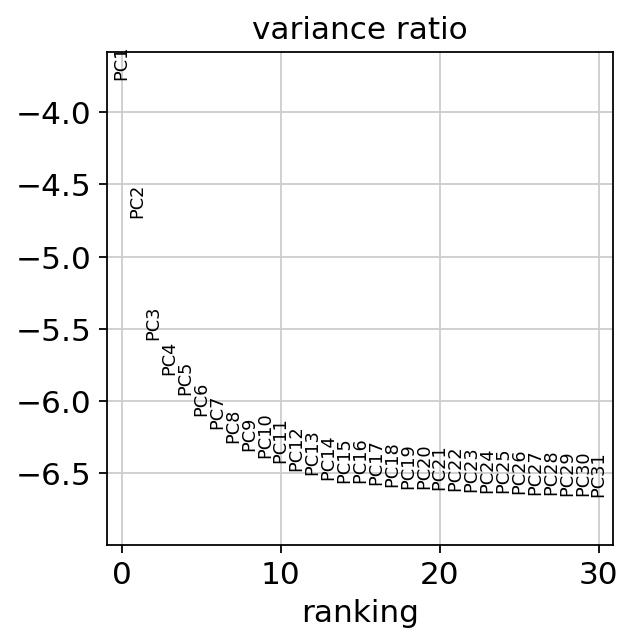

In [22]:
sc.pl.pca_variance_ratio(bin_adata, log=True)

In [23]:
%%time
# building neighborhood graph
sc.pp.neighbors(bin_adata, n_neighbors=10, n_pcs=20)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:01)
CPU times: user 2.5 s, sys: 1.78 s, total: 4.28 s
Wall time: 1.96 s


In [24]:
%%time
sc.tl.umap(bin_adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)
CPU times: user 3.95 s, sys: 1.98 s, total: 5.93 s
Wall time: 3.53 s


In [25]:
bin_adata

AnnData object with n_obs × n_vars = 1179 × 62161 
    obs: 'cell_id', 'celltype', 'condition'
    uns: 'pca', 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

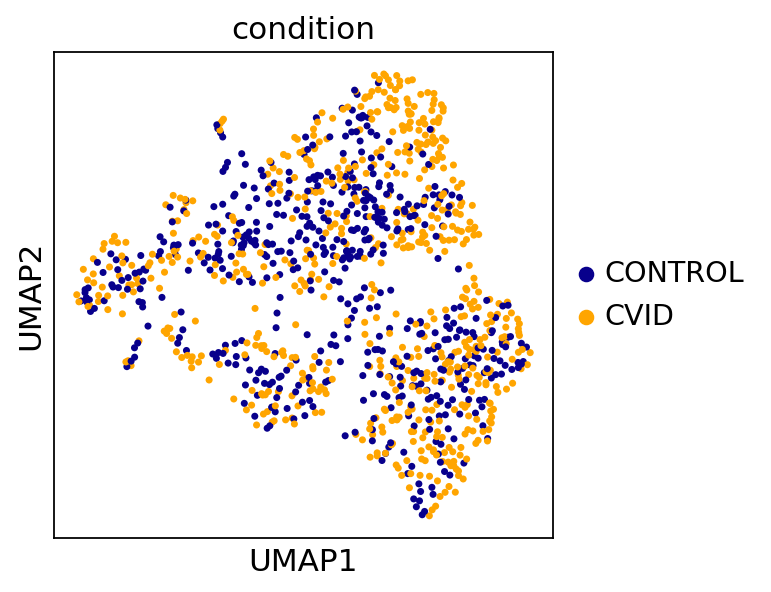

In [31]:
sc.pl.umap(bin_adata, color='condition', s=40, palette = ['#08008c','#ffa500'],
          save='_atac_condition.pdf')

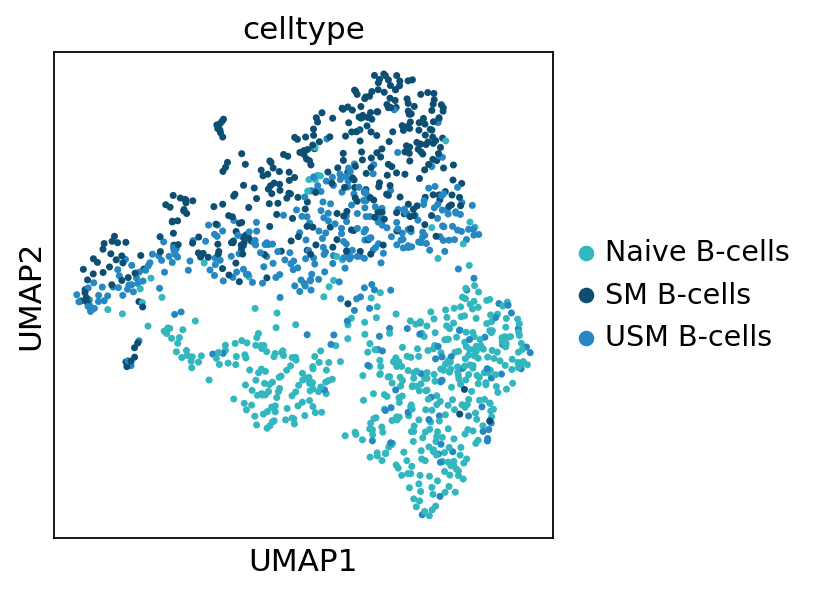

In [32]:
sc.pl.umap(bin_adata, color='celltype', s=40, palette = ['#32b7bf',
                                                         '#0c4f73', '#2688c2'],
          save='_atac_celltype.pdf')

In [33]:
# saving this object
bin_adata.write('bin_adata_atac_object_final.h5ad')

In [34]:
bin_adata = sc.read('bin_adata_atac_object_final.h5ad')